In [1]:
import numpy as np
import gym
from gym.spaces import Discrete, Box
import torch.nn as nn
import torch
import torch.optim as opt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib
import torchvision.transforms as T
from torch.distributions import Categorical, Normal
from scipy import signal
import scipy
from torch import optim
import core
from torchvision.transforms import InterpolationMode
from torch.utils.tensorboard import SummaryWriter
import imageio
from PIL import Image


In [2]:
def statistics_scalar(x, with_min_and_max=False):
    """
    Get mean/std and optional min/max of scalar x across MPI processes.

    Args:
        x: An array containing samples of the scalar to produce statistics
            for.

        with_min_and_max (bool): If true, return min and max of x in 
            addition to mean and std.
    """
    x = np.array(x, dtype=np.float32)
    global_sum, global_n = np.sum(x), len(x)
    mean = global_sum / global_n

    global_sum_sq = np.sum((x - mean)**2)
    std = np.sqrt(global_sum_sq / global_n)  # compute global std

    if with_min_and_max:
        global_min =np.min(x) if len(x) > 0 else np.inf
        global_max =np.max(x) if len(x) > 0 else -np.inf
        return mean, std, global_min, global_max
    return mean, std

In [3]:
class VPGBuffer:
    def __init__(self, obs_dim, c, h, w, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.frame_buf = np.zeros(core.combined_shape(size, (c, h, w)), dtype=np.float32)
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, frame, obs, act, rew, val, logp):
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.frame_buf[self.ptr] = frame
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = core.discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = core.discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        data = dict(frames=self.frame_buf, obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}


In [ ]:
def get_screen_CartPole_v0(env):                             
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    # time.sleep(2)
    # env = env()
    screen = env.render(mode='rgb_array')
    screen  = screen.transpose((2, 0, 1))
    # screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    def get_cart_location(screen_width):
        world_width = env.x_threshold * 2
        scale = screen_width / world_width
        return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                    T.ToTensor()])
    return resize(screen).unsqueeze(0)

In [ ]:
def get_screen_CartPole_v0(env):                             
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    # time.sleep(2)
    # env = env()
    screen = env.render(mode='rgb_array')
    screen  = screen.transpose((2, 0, 1))
    # screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.88)]
    view_width = int(screen_width * 0.67)
    def get_cart_location(screen_width):
        world_width = env.x_threshold * 2
        scale = screen_width / world_width
        return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                    T.ToTensor()])
    return resize(screen).unsqueeze(0)

In [6]:
env = 'CartPole-v0'
# env = gym.make('CartPole-v0')
def vpg(env_fn, actor_critic=core.ActorCritic, ac_kwargs=dict(),  seed=0, 
        steps_per_epoch=4000, epochs=50, gamma=0.99, pi_lr=3e-4,
        vf_lr=1e-3, train_v_iters=80, lam=0.97, max_ep_len=1000,
        tb=SummaryWriter(), save_freq=10, get_screen=None):
    
    # Random seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Instantiate environment
    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape
    env.reset()
    env.render()
    
    def get_screen(env):                             
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        # time.sleep(2)
        # env = env()
        screen = env.render(mode='rgb_array')
        screen  = screen.transpose((2, 0, 1))
        # screen = env.render(mode='rgb_array').transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        def get_cart_location(screen_width):
            world_width = env.x_threshold * 2
            scale = screen_width / world_width
            return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
        cart_location = get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        resize = T.Compose([T.ToPILImage(),
                        T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                        T.ToTensor()])
        return resize(screen).unsqueeze(0)

    _, c, h, w = get_screen(env).shape

    # Create actor-critic module
    ac = actor_critic(c, h, w, env.action_space, **ac_kwargs)

    var_counts = {module[0]:core.count_vars(module[1]) for module in [['Pi', ac.pi], ['V', ac.v]]}
    tb.add_scalars('Number of parameters', var_counts, 1)

    # Set up experience buffer
    local_steps_per_epoch = int(steps_per_epoch)
    buf = VPGBuffer(obs_dim, c, h, w, act_dim, local_steps_per_epoch, gamma, lam)

    # Set up function for computing VPG policy loss
    def compute_loss_pi(data):
        frames, obs, act, adv, logp_old = data['frames'], data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = ac.pi(frames, act)
        loss_pi = -(logp * adv).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        pi_info = dict(kl=approx_kl, ent=ent)
        
        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(data):
        frames, obs, ret = data['frames'], data['obs'], data['ret']
        return ((ac.v(frames) - ret)**2).mean()

    # Set up optimizers for policy and value function
    pi_optimizer = opt.Adam(ac.pi.parameters(), lr=pi_lr)
    vf_optimizer = opt.Adam(ac.v.parameters(), lr=vf_lr)

    def update(epoch):
        data = buf.get()

        # Get loss and info values before update
        pi_l_old, pi_info_old = compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = compute_loss_v(data).item()

        # Train policy with a single step of gradient descent
        pi_optimizer.zero_grad()
        loss_pi, pi_info = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Value function learning
        for i in range(train_v_iters):
            vf_optimizer.zero_grad()
            loss_v = compute_loss_v(data)
            loss_v.backward()
            vf_optimizer.step()

        kl, ent = pi_info['kl'], pi_info_old['ent']
        info = dict(LossPi=pi_l_old, LossV=v_l_old,
                    KL=kl, Entropy=ent,
                    DeltaLossPi=(loss_pi.item() - pi_l_old),
                    DeltaLossV=(loss_v.item() - v_l_old))
        tb.add_scalars('Info', info, epoch)

    def generate_gif(env, filename, T=200):
        frames2 = []
        s_t = env.reset()
        reward = 0
        for t in range(T):
            # a_t = agent.act(s_t)
            frame2 = get_screen()
            # action_probs = ac.pi(torch.FloatTensor(frame)).detach().numpy().squeeze()
            a2, v2, logp2 = ac.step(frame)
            # action_probs = model(torch.FloatTensor(frame)).detach().numpy().squeeze()
            # print(action_probs)
            # action_probs = [0.5, 0.5]
            # action = np.random.choice(env.action_space, p=action_probs)
            s_2, r2, done2, info2 = env.step(a2[0])
            # s_t, r_t, d_t, _ = env.step(action)
            frame_2 = env.render(mode='rgb_array')
            frames2.append(frame_2)
            reward2 += r2
            if done2:
                break
        print(reward2)
        images_list = [Image.fromarray(frame2) for frame2 in frames2]
        imageio.mimsave(f'{filename}.gif', frames2, duration=0.02)

    # Prepare for interaction with environment
    frame, o, ep_ret, ep_len = get_screen(env), env.reset(), 0, 0
    ep_no = 0
    # Main loop: collect experience in env and update/log each epoch
    for epoch in tqdm(range(epochs)):
        for t in tqdm(range(local_steps_per_epoch)):
            a, v, logp = ac.step(torch.as_tensor(frame, dtype=torch.float32))

            next_o, r, d, _ = env.step(a[0])
            frame_ = get_screen(env)
            ep_ret += r
            ep_len += 1

            # save and log
            buf.store(frame, o, a, r, v, logp)
            tb.add_scalar('VVals', v, epoch*local_steps_per_epoch+t)
            # Update obs (critical!)
            o = next_o
            frame = frame_

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t==local_steps_per_epoch-1

            if terminal or epoch_ended:
                if epoch_ended and not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)
                # if trajectory didn't reach terminal state, bootstrap value target
                if timeout or epoch_ended:
                    _, v, _ = ac.step(torch.as_tensor(frame, dtype=torch.float32))
                else:
                    v = 0
                buf.finish_path(v)
                if terminal:
                    ep_no+=1
                    # only save EpRet / EpLen if trajectory finished
                    ep_data = dict(EpRet=ep_ret, EpLen=ep_len)
                    tb.add_scalars('Episode data', ep_data, ep_no)
                frame, o, ep_ret, ep_len = get_screen(env), env.reset(), 0, 0


        # Save model
        if (epoch % save_freq == 0) or (epoch == epochs-1):
            torch.save(ac, './HalfCheatah_VPG')

        # Perform VPG update!
        update(epoch)
        generate_gif(env, './HalfCheatah_VPG_gifs/%d.gif'%epoch)

        

In [41]:
env2 = gym.make('CartPole-v0')
env2.reset()
env2.x_threshold


2.4

In [44]:
env = "HalfCheetah-v2"
env_ = gym.make(env)
env_.reset()
a = env_.action_space.sample()
env_.step(a)
env_.render()

Creating window glfw


In [77]:
env = "HalfCheetah-v2"
env_ = gym.make(env)
env_.reset()

array([ 0.02985872, -0.05849089, -0.00778534,  0.03018266,  0.09013194,
       -0.09435839,  0.02093375,  0.00329209,  0.08668068,  0.03327441,
       -0.15921935, -0.02892676, -0.01402517,  0.10266647,  0.15184982,
       -0.01070896, -0.13903689])

In [109]:
resize = T.Compose([T.ToPILImage(),
                T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                T.ToTensor()])
# env_.render()
h, w, c = env_.render('rgb_array').shape
screen = env_.render(mode='rgb_array')
screen  = screen.transpose((2, 0, 1))
# screen = env.render(mode='rgb_array').transpose((2, 0, 1))
# Cart is in the lower half, so strip off the top and bottom of the screen
_, screen_height, screen_width = screen.shape
# print(screen.shape)
# get1 = resize(screen).unsqueeze(0)
screen = screen[:, int(screen_height*0.4):int(screen_height * 0.88)]
# _, screen_height, screen_width = screen.shape
# get2 = resize(screen).unsqueeze(0)
# print(screen.shape)
view_width = int(screen_width * 0.67)
# def get_cart_location(screen_width):
#     world_width = env.x_threshold * 2
#     scale = screen_width / world_width
#     return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
cart_location = screen_width / 2.0
slice_range = 0
if cart_location < view_width // 2:
    slice_range = slice(view_width)
    print('L')
elif cart_location > (screen_width - view_width // 2):
    slice_range = slice(-view_width, None)
    print('LL')
else:
    slice_range = slice(int(cart_location - view_width // 2),
                        int(cart_location + view_width // 2))
    print('LLL')
# Strip off the edges, so that we have a square image centered on a cart
print(slice_range)
screen = screen[:, :, slice_range]
# Convert to float, rescale, convert to torch tensor
# (this doesn't require a copy)
screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
screen = torch.from_numpy(screen)
# Resize, and add a batch dimension (BCHW)

get = resize(screen).unsqueeze(0)
# tb.close()


(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


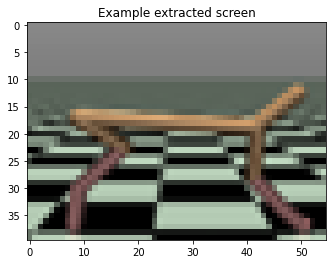

In [110]:
# env_.reset()
# print(env.render(mode="rgb_array"))
plt.figure()
plt.imshow(get.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
# plt.imshow(get1.cpu().squeeze(0).permute(1, 2, 0).numpy(),
        #    interpolation='none')
# plt.imshow(get2.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


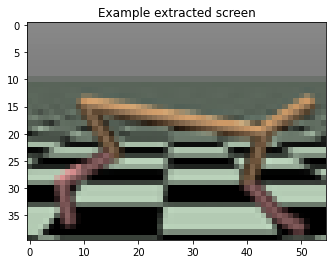

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


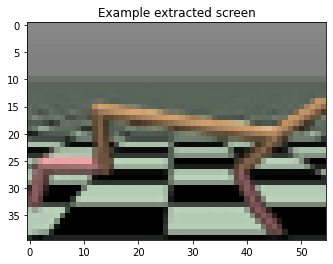

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


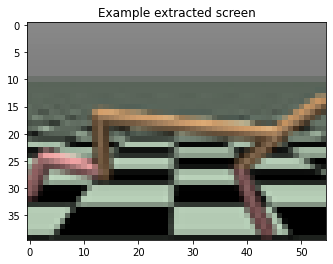

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


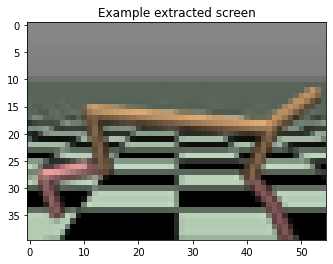

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


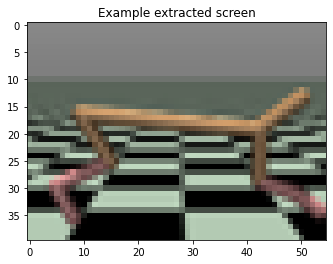

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


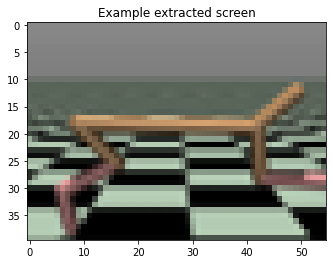

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


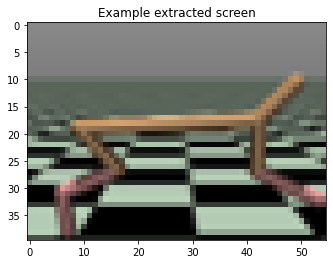

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


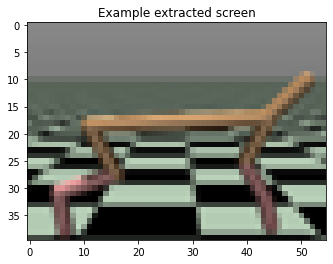

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


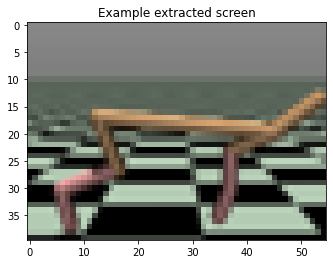

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


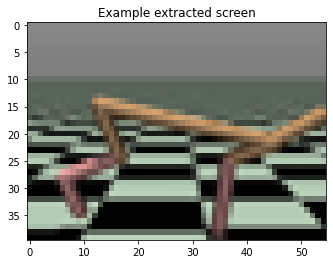

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


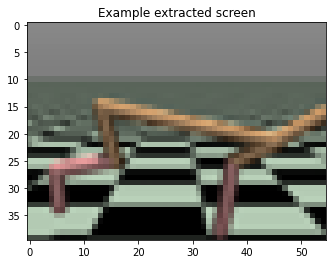

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


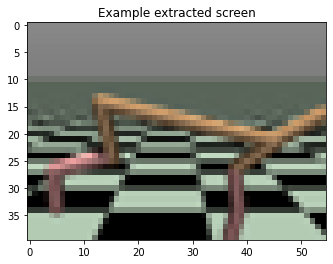

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


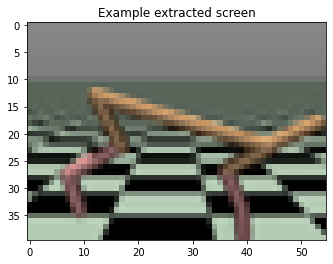

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


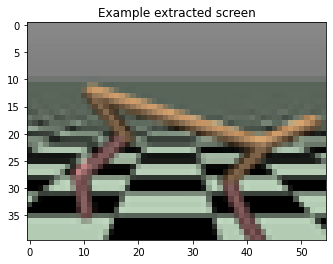

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


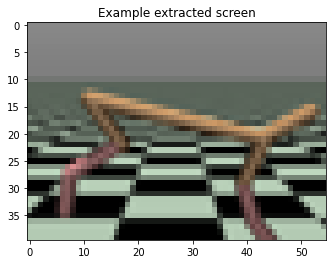

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


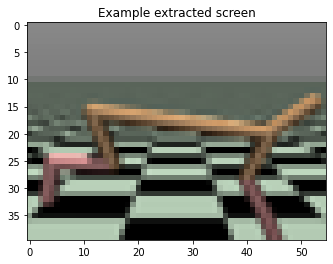

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


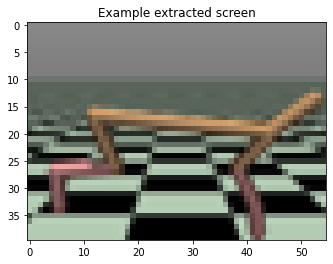

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


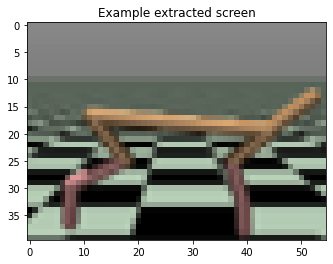

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


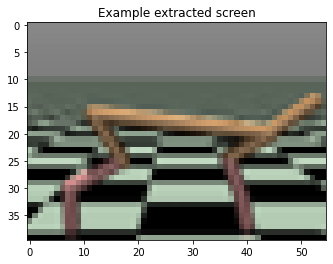

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


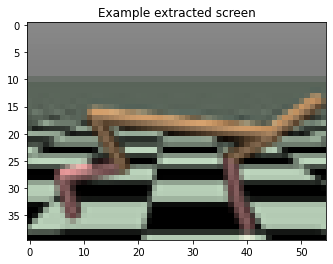

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


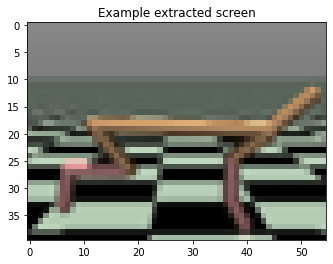

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


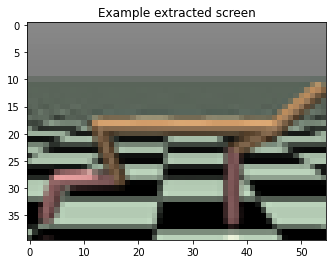

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


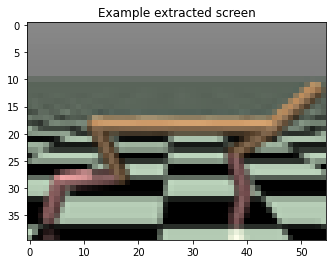

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


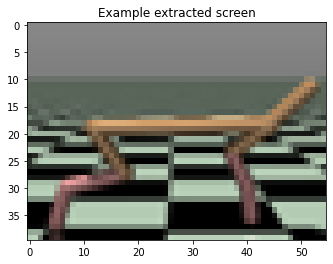

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


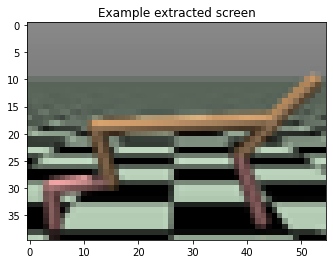

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


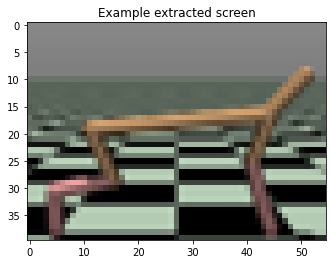

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


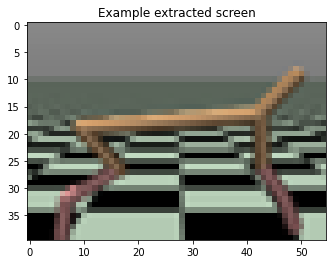

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


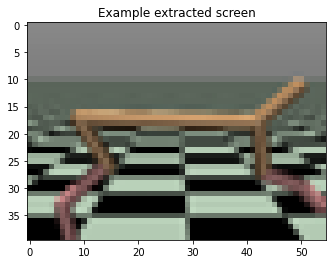

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


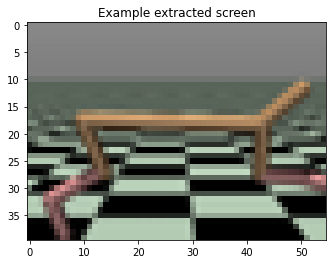

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


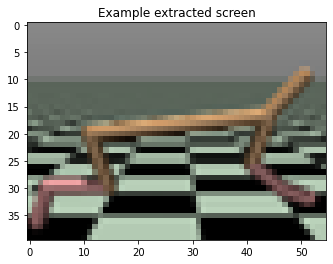

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


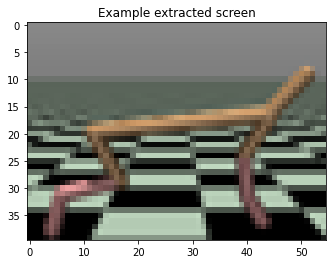

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


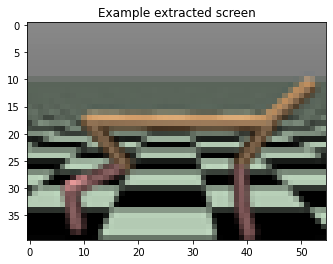

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


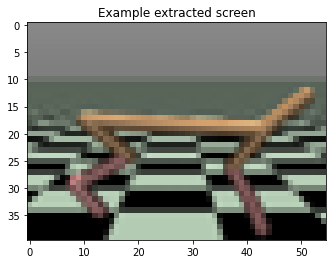

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


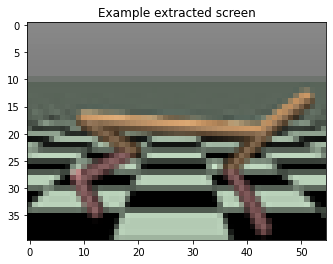

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


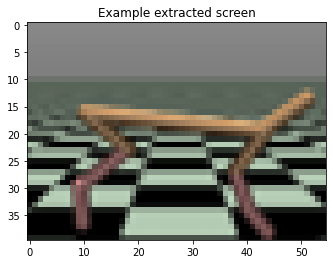

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


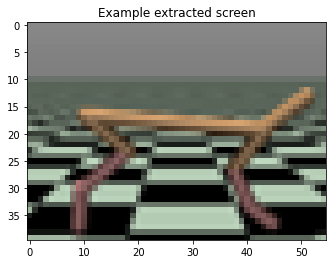

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


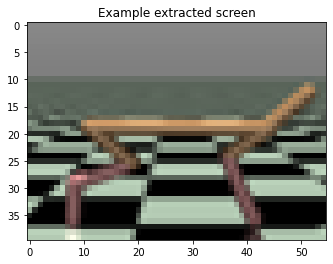

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


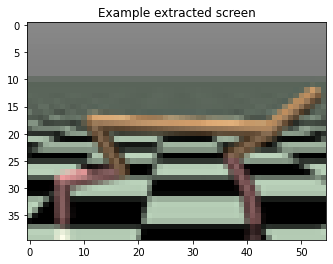

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


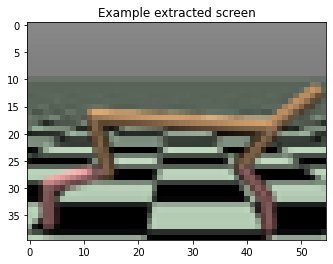

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


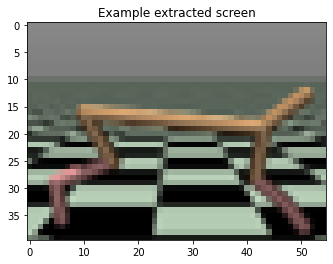

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


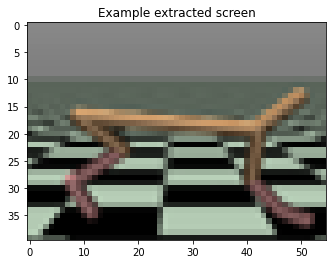

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


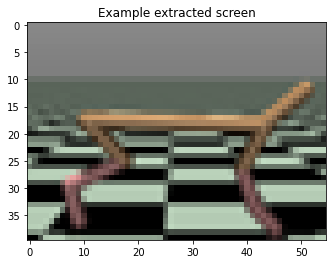

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


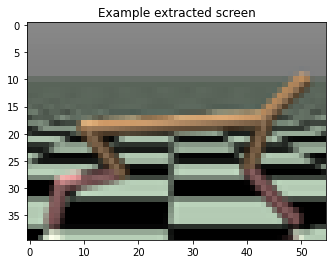

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


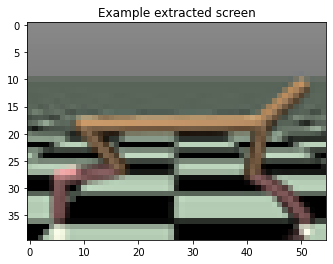

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


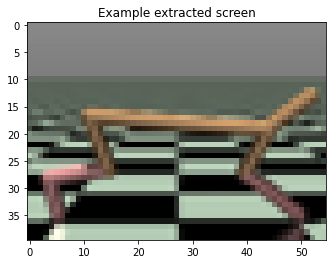

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


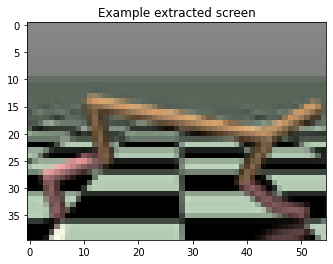

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


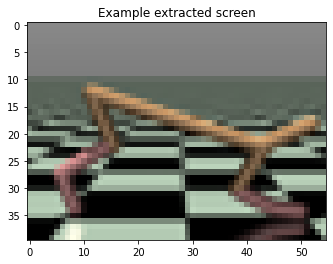

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


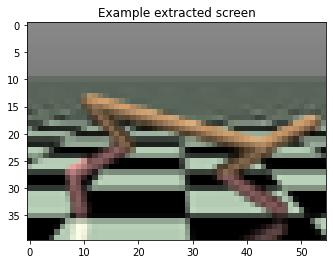

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


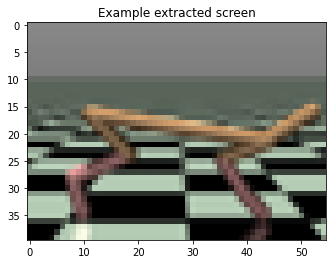

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


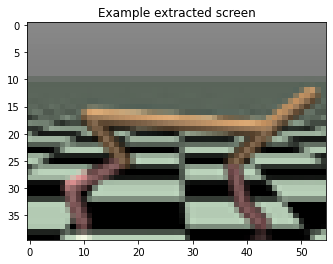

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


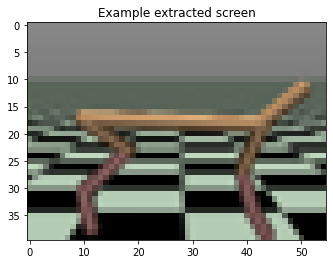

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


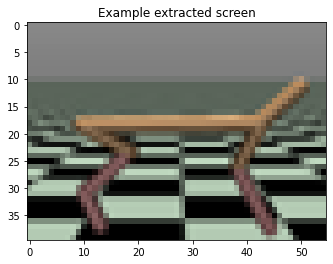

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


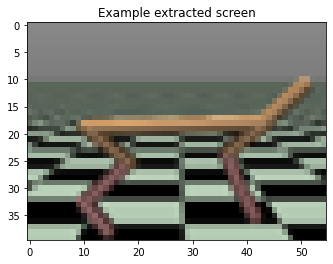

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


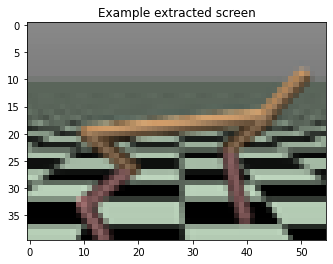

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


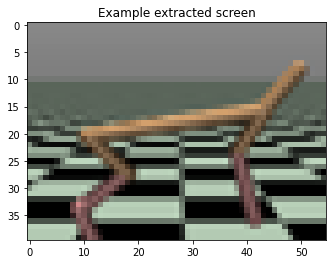

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


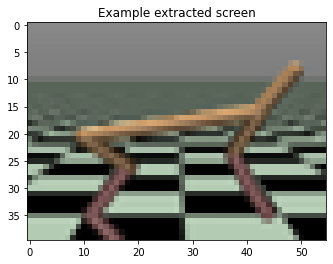

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


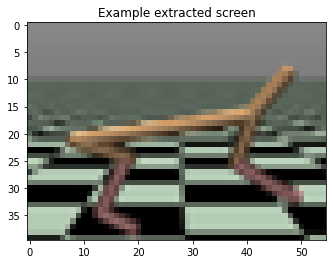

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


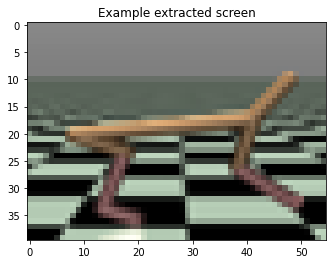

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


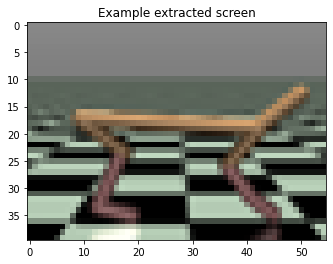

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


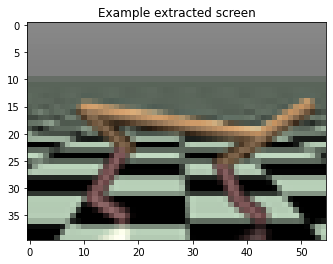

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


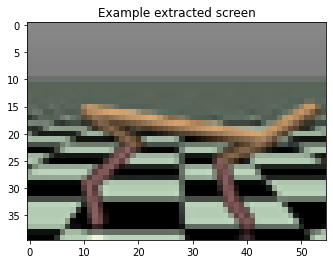

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


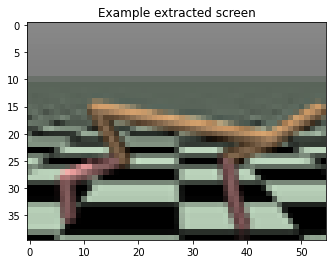

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


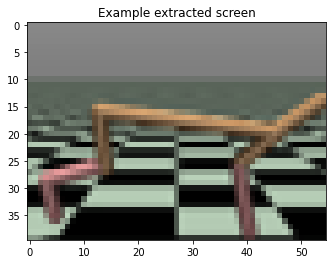

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


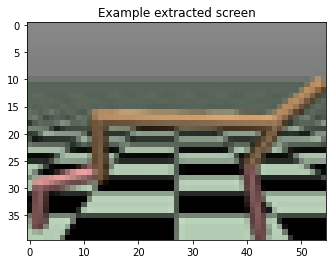

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


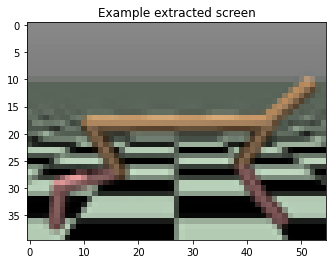

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


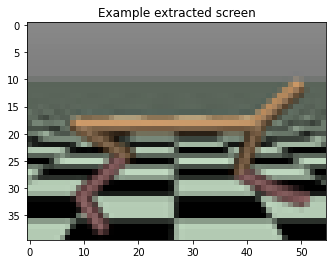

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


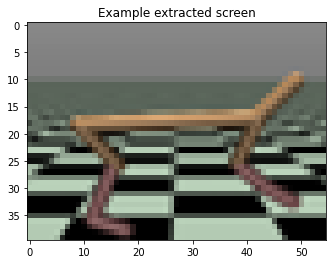

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


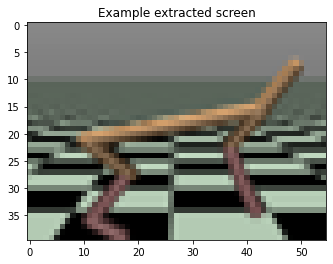

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


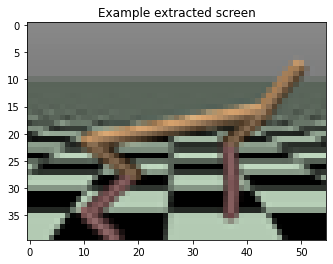

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


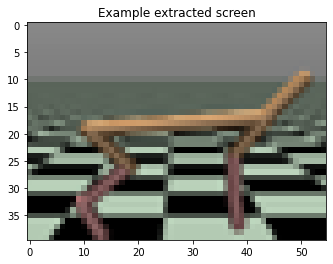

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


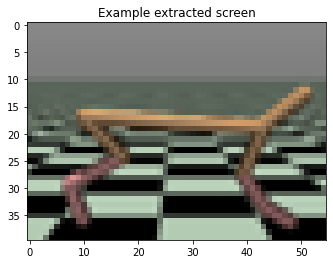

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


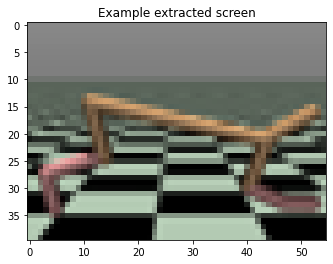

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


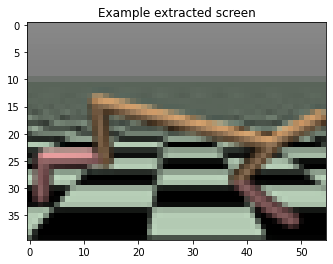

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


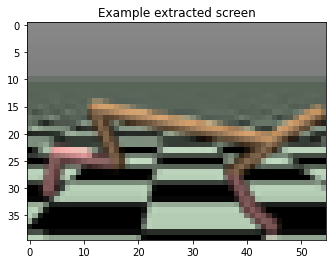

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


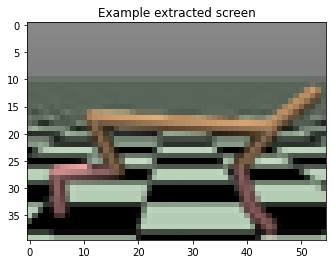

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


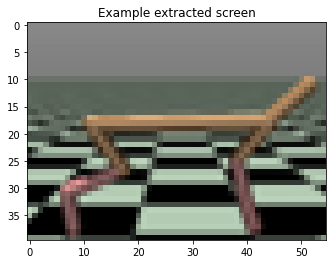

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


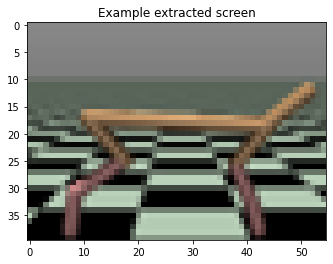

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


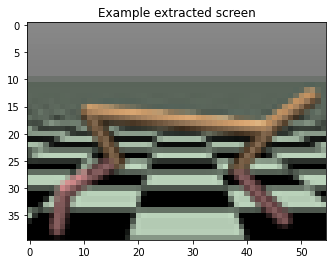

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


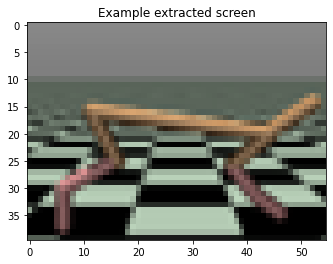

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


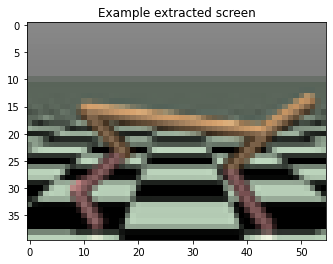

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


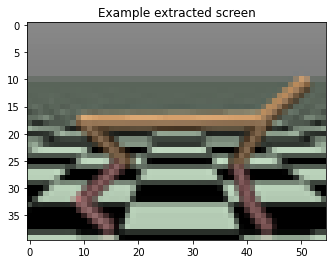

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


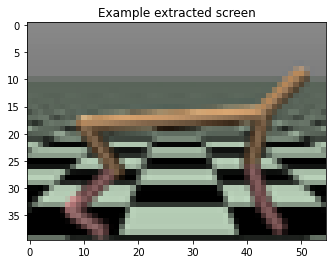

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


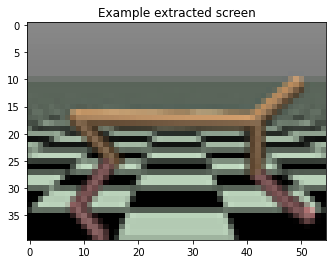

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


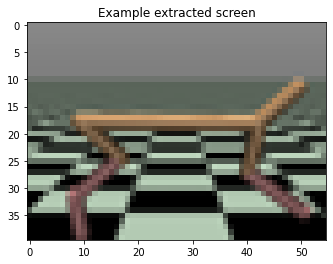

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


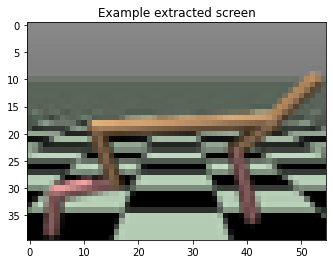

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


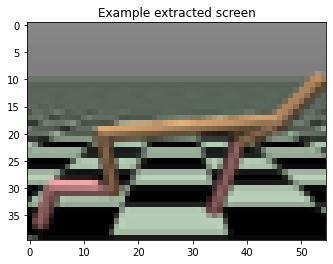

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


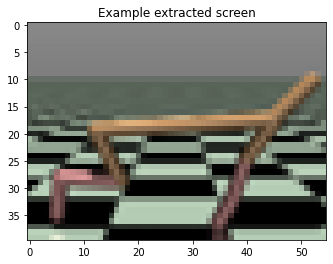

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


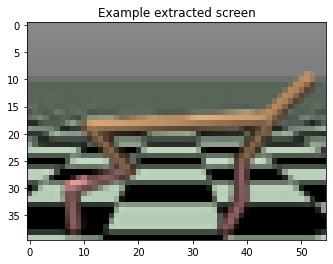

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


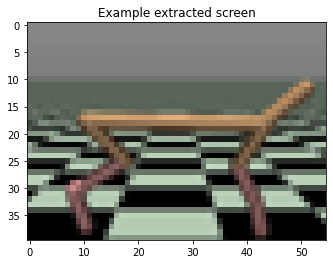

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


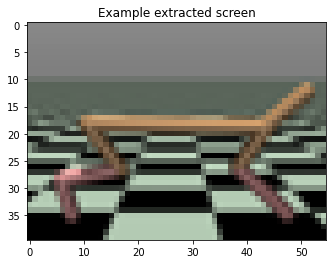

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


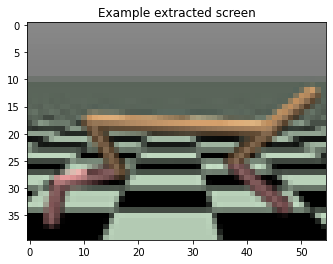

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


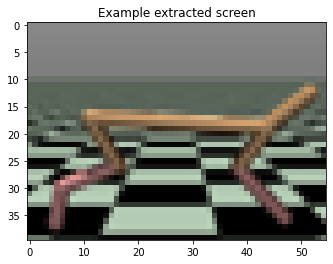

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


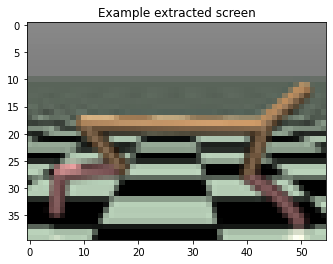

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


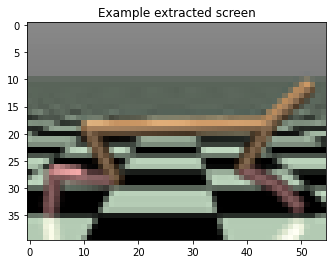

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


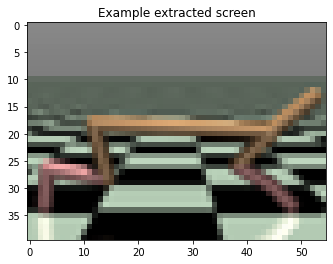

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


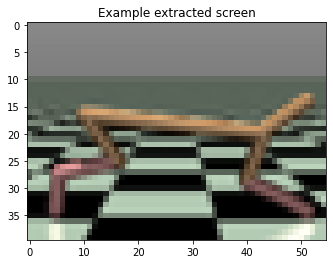

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


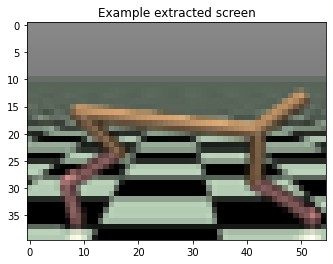

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


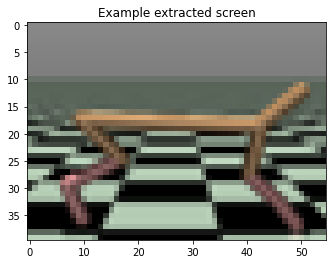

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


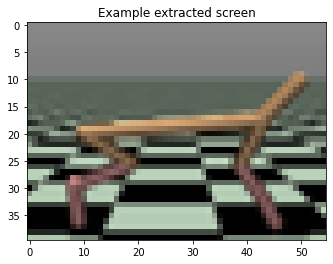

(3, 500, 500)
(3, 240, 500)
LLL
slice(83, 417, None)


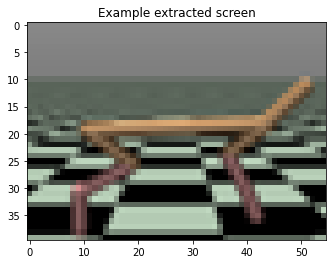

In [111]:
for i in range(100):
    env_.step(env_.action_space.sample())
    resize = T.Compose([T.ToPILImage(),
                T.Resize(40, interpolation=InterpolationMode.BICUBIC),
                T.ToTensor()])
    # env_.render()
    h, w, c = env_.render('rgb_array').shape
    screen = env_.render(mode='rgb_array')
    screen  = screen.transpose((2, 0, 1))
    # screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    # print(screen.shape)
    # get1 = resize(screen).unsqueeze(0)
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.88)]
    # _, screen_height, screen_width = screen.shape
    # get2 = resize(screen).unsqueeze(0)
    # print(screen.shape)
    view_width = int(screen_width * 0.67)
    # def get_cart_location(screen_width):
    #     world_width = env.x_threshold * 2
    #     scale = screen_width / world_width
    #     return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
    cart_location = screen_width / 2.0
    slice_range = 0
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
        print('L')
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
        print('LL')
    else:
        slice_range = slice(int(cart_location - view_width // 2),
                            int(cart_location + view_width // 2))
        print('LLL')
    # Strip off the edges, so that we have a square image centered on a cart
    print(slice_range)
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)

    get = resize(screen).unsqueeze(0)
    plt.figure()
    plt.imshow(get.cpu().squeeze(0).permute(1, 2, 0).numpy(),
            interpolation='none')
    # plt.imshow(get1.cpu().squeeze(0).permute(1, 2, 0).numpy(),
            #    interpolation='none')
    # plt.imshow(get2.cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
    plt.title('Example extracted screen')
    plt.show()
    plt.close()
        # env_.render()

In [9]:
tb = SummaryWriter('./HalfCheatah_VPG')

In [10]:
vpg(lambda : gym.make(env), actor_critic=core.ActorCritic, tb=tb, seed = 1)

Creating window glfw


AttributeError: 'HalfCheetahEnv' object has no attribute 'x_threshold'

In [ ]:
import imageio
from PIL import Image

def generate_gif(env, filename, T=200):
    frames = []
    s_t = env.reset()
    reward = 0
    for t in range(T):
        # a_t = agent.act(s_t)
        frame = 
        # action_probs = ac.pi(torch.FloatTensor(frame)).detach().numpy().squeeze()
        a, v, logp = ac.step(frame)
        # action_probs = model(torch.FloatTensor(frame)).detach().numpy().squeeze()
        # print(action_probs)
        # action_probs = [0.5, 0.5]
        # action = np.random.choice(env.action_space, p=action_probs)
        s_, r, done, info = env.step(a[0])
        # s_t, r_t, d_t, _ = env.step(action)
        frame_ = env.render(mode='rgb_array')
        frames.append(frame_)
        reward += r
        if done:
            break
    print(reward)
    images_list = [Image.fromarray(frame) for frame in frames]
    imageio.mimsave(f'{filename}.gif', frames, duration=0.02)